<a href="https://colab.research.google.com/github/amankiitg/5DParallel/blob/main/Llama_Memory_Usage_Buckets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

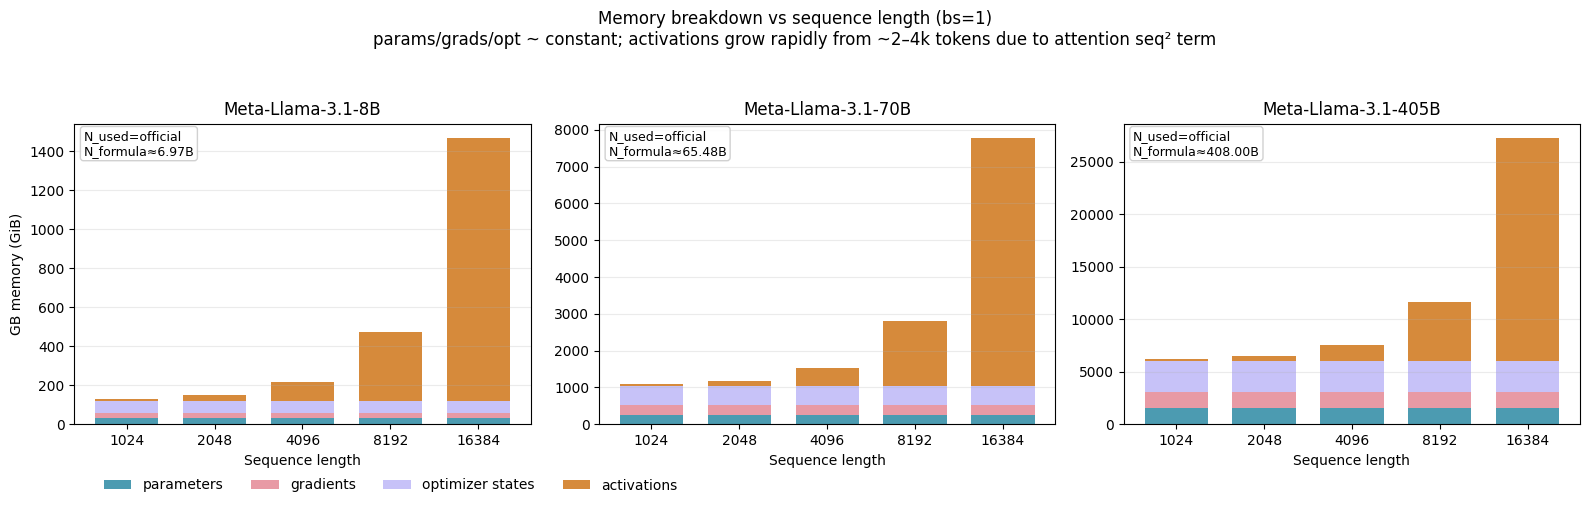

In [1]:
# Colab-ready: replicate the stacked VRAM plots using the formulas you provided.
# (Parameters / gradients / optimizer states are ~independent of seq;
#  activations explode with seq due to the seq^2 attention term.)

import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1) Formulas you referenced
# -----------------------------
def N_simple_transformer(h, v, L):
    """
    Parameter-count estimate for a 'simple transformer' (as in your screenshot):
      N = h*v + L*(12*h^2 + 13*h) + 2*h
    NOTE: This is an estimate; Llama uses SwiGLU/GQA/untied embeddings etc,
    so this will not exactly equal the marketed 8B/70B/405B counts.
    """
    return h * v + L * (12 * (h**2) + 13 * h) + 2 * h

def m_params_bytes(N):  # screenshot: m_params = 4 * N
    return 4 * N

def m_grad_bytes(N):    # screenshot: m_grad = 4 * N
    return 4 * N

def m_opt_bytes(N):     # screenshot: m_opt = (4 + 4) * N  (Adam m and v in FP32)
    return (4 + 4) * N

def m_act_bytes(L, seq, bs, h, n_heads):
    """
    From your reference derivation:
      activation memory per layer = s*b*h * (34 + 5*a*s/h)  bytes
    so total:
      m_act = L * s*b*h * (34 + 5*a*s/h)
    """
    s, b, a = seq, bs, n_heads
    return L * s * b * h * (34 + (5 * a * s) / h)

def bytes_to_gib(x):
    return x / (1024**3)

# -----------------------------
# 2) Model configs (Llama 3.1 family)
#    Using widely-circulated HF config values:
#    8B:   h=4096,  L=32,  heads=32,  vocab=128256
#    70B:  h=8192,  L=80,  heads=64,  vocab=128256
#    405B: h=16384, L=126, heads=128, vocab=128256
# -----------------------------
V = 128256
models = {
    "Meta-Llama-3.1-8B":   {"h": 4096,  "L": 32,  "heads": 32,  "v": V, "N_official": 8e9},
    "Meta-Llama-3.1-70B":  {"h": 8192,  "L": 80,  "heads": 64,  "v": V, "N_official": 70e9},
    "Meta-Llama-3.1-405B": {"h": 16384, "L": 126, "heads": 128, "v": V, "N_official": 405e9},
}

# Choose how to set N for params/grads/opt:
# - If you want to strictly use the N formula: set USE_OFFICIAL_N=False
# - If you want bars closer to the "8B/70B/405B" labels: set USE_OFFICIAL_N=True
USE_OFFICIAL_N = True

# Batch size in the plot (bs=1 matches the dramatic seq^2 activation blow-up story)
BS = 1

# X-axis sequence lengths in the figure
seqs = np.array([1024, 2048, 4096, 8192, 16384], dtype=int)

# -----------------------------
# 3) Compute memory breakdowns + plot
# -----------------------------
colors = {
    "parameters": "#4C9BB1",
    "gradients": "#E89AA5",
    "optimizer": "#C7C2F8",
    "activations": "#D68A3B",
}

fig, axes = plt.subplots(1, 3, figsize=(16, 4.5), sharey=False)

for ax, (name, cfg) in zip(axes, models.items()):
    h, L, a, v = cfg["h"], cfg["L"], cfg["heads"], cfg["v"]

    N_est = N_simple_transformer(h=h, v=v, L=L)
    N = cfg["N_official"] if USE_OFFICIAL_N else N_est

    # constant across seq (per your statement)
    params_gib = bytes_to_gib(m_params_bytes(N))
    grads_gib  = bytes_to_gib(m_grad_bytes(N))
    opt_gib    = bytes_to_gib(m_opt_bytes(N))

    # varies with seq (activation formula)
    acts_gib = np.array([bytes_to_gib(m_act_bytes(L=L, seq=s, bs=BS, h=h, n_heads=a)) for s in seqs])

    # Prepare stacked bars
    x = np.arange(len(seqs))
    width = 0.72

    p1 = ax.bar(x, np.full_like(seqs, params_gib, dtype=float), width, label="parameters", color=colors["parameters"])
    p2 = ax.bar(x, np.full_like(seqs, grads_gib,  dtype=float), width, bottom=np.full_like(seqs, params_gib, dtype=float),
                label="gradients", color=colors["gradients"])
    p3 = ax.bar(x, np.full_like(seqs, opt_gib,    dtype=float), width,
                bottom=np.full_like(seqs, params_gib+grads_gib, dtype=float),
                label="optimizer states", color=colors["optimizer"])
    p4 = ax.bar(x, acts_gib, width,
                bottom=np.full_like(seqs, params_gib+grads_gib+opt_gib, dtype=float),
                label="activations", color=colors["activations"])

    ax.set_title(name)
    ax.set_xticks(x)
    ax.set_xticklabels([str(s) for s in seqs])
    ax.set_xlabel("Sequence length")
    ax.grid(True, axis="y", alpha=0.25)

    # Print N info on plot (so you can see what you're using)
    ax.text(
        0.02, 0.98,
        f"N_used={'official' if USE_OFFICIAL_N else 'formula'}\n"
        f"N_formula≈{N_est/1e9:.2f}B",
        transform=ax.transAxes,
        va="top",
        ha="left",
        fontsize=9,
        bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="0.8", alpha=0.9),
    )

axes[0].set_ylabel("GB memory (GiB)")

# One shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower left", bbox_to_anchor=(0.06, -0.05), ncol=4, frameon=False)

fig.suptitle(
    "Memory breakdown vs sequence length (bs=1)\n"
    "params/grads/opt ~ constant; activations grow rapidly from ~2–4k tokens due to attention seq² term",
    y=1.05
)

plt.tight_layout()
plt.show()
